<a href="https://colab.research.google.com/github/CharlesCoster/ada-project-terrorism-impact/blob/master/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from PIL import Image
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from collections import defaultdict
from collections import OrderedDict
import operator

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

In [0]:
import plotly
import chart_studio
from chart_studio import plotly as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import plot
import plotly.io as pio

In [0]:
#!pip install networkx==2.3
import networkx as nx
from networkx.algorithms import bipartite
from itertools import count

In [0]:
from bokeh.io import show, output_file, output_notebook
from bokeh.models import Plot, Range1d, MultiLine, Circle, ColorBar,LogTicker
from bokeh.models import Panel, Tabs
from bokeh.models import HoverTool, TapTool, BoxSelectTool, WheelZoomTool, ResetTool, WheelPanTool, PanTool
from bokeh.models.graphs import from_networkx
from bokeh.models.graphs import NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.palettes import Spectral4, YlOrRd
from bokeh.transform import linear_cmap
from bokeh.embed import file_html
from bokeh.resources import CDN

In [0]:
%%capture
%matplotlib inline
from ipywidgets import interact, widgets
from IPython.display import display, Image

import matplotlib.pyplot as plt
from ipywidgets.embed import embed_minimal_html

In [0]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [0]:
# Figures hosted on Plotly
username = 'hugaguett' # your username
api_key = 'W8qvJNV8CuGSfxeZTWQK' # your api key - go to profile > settings > regenerate key
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

In [115]:
!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Abstract


For the past hundreds of years, the World has suffered globalized terrorist attacks that had considerable consequences on citizen’s life all around the world. At different time periods, some continents have been impacted by a lot of terrorist attacks due to conflictual situations (Western Europe and Africa during the last decades, Ireland and the UK between the 70's and the ‘90s, South America and Asia during the communist-socialist era). Those terrorists attacks have different goals (religious, political, ideological) but they always impact the life of the citizen of the country/city that they target. Today, not only will we present to you the bare truth about terrorism in our globalized world during the last 50 years (and not just what the media wants you to hear!) but we will also present you with few insights found alongside our study and observation of those terror attacks dataset.


# Introduction

## Motivation
What motivates us to give such a detailed analysis of global terrorism over the last century is that according to us there are lessons to be learned from the past. In our opinion studying patterns in terror attacks and group can help to understand them better and take some precautions, observing the real data of terrorism and its impact on the everyday life of a worldwide citizen is also as informative as helpful to get rid of the irrational fear one can have. To finish with, we tried to “predict” from past data how some countries are linked in regards to global terrorism, this helped us “predict” a following attack occurring in a country if a linked country has been attacked just before. Indeed, we are not going to pretend that we have found ways to prevent a terrorist attack to ever happen again, but if our study can reduce this impact or prevent some of those disasters to occur, even if people just feel more informed about it. Then, we will have reached our goal.


## Datasets

In this project, we used data from many sources. The main part of our analysis is done with the [Global Terrorism Database (GTD)](https://www.start.umd.edu/research-projects/global-terrorism-database-gtd) which is a database of terrorist incidents from 1970 onward. As of July 2017, the list extended through 2016, with an incomplete data of 1993 due to issues with that year. The database is maintained by the National Consortium for the Study of Terrorism and Responses to Terrorism (START) at the University of Maryland, College Park in the United States. We also had a look on terrorist groups using the [Extended Data on Terrorist Groups (EDTG)](https://journals.sagepub.com/doi/full/10.1177/0022002719857145), an extended data set of 760 terrorist groups that were engaged in attacks during 1970 to 2016. EDTG is linked to terrorist groups and attacks given in the Global Terrorism Database. Terrorist groups’ variables in EDTG include ideology, main goals, start date, duration, base country, attack diversity, peak size, alternative endings (if relevant), and others. Data about Happiness come from the [World Happiness Report](https://worldhappiness.report/ed/2015/), a landmark survey of the state of global happiness that ranks 156 countries by how happy their citizens perceive themselves to be. Finally, we used the [Fragile States Index (FSI)](https://fragilestatesindex.org/methodology/) produced by The Fund for Peace (FFP), which is a critical tool in highlighting not only the normal pressures that all states experience, but also in identifying when those pressures are outweighing a states’ capacity to manage them. 


## Infographie

In [0]:
# We import dblp from google drive
id='1bfZzGpT5jQwYuLHfdgPO_4JSLyPsIVBR'
file="globalterrorismdb_0919dist.xlsx"

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile(file)  

# Global terrorism dataset
gtdb_df = pd.read_excel(file)
#We keep terrorist attacks which fulfills criterions of terrorism
crit_gtdb_df = gtdb_df[gtdb_df.crit1.isin([1])&gtdb_df.crit2.isin([1])&gtdb_df.crit3.isin([1])]

In [117]:
# Get descriptive information of the dataset
period = crit_gtdb_df.iyear.max() - crit_gtdb_df.iyear.min()
nattacks = crit_gtdb_df.eventid.count()
nkills = crit_gtdb_df.nkill.sum()
ncountries = len(crit_gtdb_df.country.unique())
ngroups = len(crit_gtdb_df.gname.unique())

print(F"number of years : {period}\nnumber of attacks : {nattacks}\nnumber of kills : {nkills}\nnumber of countries : {ncountries}\nnumber of groups : {ngroups}")

number of years : 48
number of attacks : 163582
number of kills : 334211.0
number of countries : 205
number of groups : 3429


# Overall analysis

In this first section, we will be presenting the studied dataset as well as some of the interesting insights we found inside. 

## Terrorism and tourism

Firstly, we are trying to find a correlation between tourism and terrorism. After observing general trends, we decided to focus on touristic data from 2010 to 2018 in Metropolitan France for its regularity and periodicity. We can see a repeating pattern with a steady increase in the tourist flow each year. When France suffered a period of intense terrorist activity from 2015 to 2016 (Bataclan : 130 kills, Nice : 86 kills).  There is a sudden drop in tourist arrivals, followed by the same steady increase as the years go by and people forget.


In [0]:
# Load tourism data in France from 2010 to 2018
file = "https://raw.githubusercontent.com/CharlesCoster/ada-project-terrorism-impact/master/ada_data/tourism.csv"
tourism_fr = pd.read_csv(file,sep=';')
tourism_fr = tourism_fr.melt(id_vars=["Place", "Tourist origin"], 
                var_name="Date", 
                value_name="Value")

tourism_fr = tourism_fr.set_index('Date')

In [0]:
# Keep only arrivals of abroad tourists
abroad_tourism = tourism_fr[tourism_fr['Tourist origin'].isin(['Abroad']) & tourism_fr['Place'].isin(['Metropolitan France'])]

In [120]:
# Plot number of arrivals in France Metropolitan as a function of the time and host figure on Plotly
fig = go.Figure()
fig.update_yaxes(range=[0, 8000000])
fig.add_trace(go.Scatter(x=abroad_tourism.index, y=abroad_tourism['Value']*1000, name="Arrivals in Metropolitan France",
                         line_color='#8a0303'))

fig.update_layout(
    showlegend=True,
    annotations=[
        go.layout.Annotation(
            x="2015-11",
            y=0,
            xref="x",
            yref="y",
            text="Bataclan attack",
            ax=0,
            ay=-300,
            arrowwidth=3,
            arrowcolor="#d62728",
        )
    ]
)

fig.update_layout(title_text='Arrival in France',
                  xaxis_rangeslider_visible=True)

fig.show()

py.plot(fig,filename="tourism", auto_open=True)

'https://plot.ly/~hugaguett/7/'

Arrivals : fonction périodique, de periode 1 an. Maximum des tourismes en ete (jullet et aout). After the Charlie Hebdo shooting (12 kills), November 2015 Paris attacks (130 kills), and more between, we observe a drop in the number of arrivals in Metropolitan France. En effet, entre 2010 et 2015, le tourism ne fait qu'augmenter mais il chute de presque 500'000 personnes.


## Happiness index and Fragility state index in world map

Next, we decided to find some correlation (and not causation) between terrorism data and the quality of life, in the most affected countries. In order to do so, we compared it to two different indexes that as far as we are concerned seems to embed well the problematics linked to terrorism in our everyday life. Hence why we chose the Happiness and Fragility state indexes for each country. Let us introduce each index first.

The happiness index is a measure of the perceived happiness of citizens published by the United Nations Sustainable Development Solutions Network each year since 2011. Data is collected from people in over 150 countries and is computed as a weighted sum of variables on a scale running from 0 to 10 that is tracked over time and compared against other countries. These variables currently include the real GDP per capita, social support, healthy life expectancy, freedom to make life choices, generosity, and perceptions of corruption (source : [Wikipedia page of the World Happiness Report](https://en.wikipedia.org/wiki/World_Happiness_Report)).

In [0]:
# Load 2015 datas about happiness and fragility state
file = "https://raw.githubusercontent.com/CharlesCoster/ada-project-terrorism-impact/master/ada_data/hi_fsi_2015.csv"
hi_fsi_df = pd.read_csv(file)
hi_fsi_df['text'] = hi_fsi_df['country'] + '<br>nattacks ' + (hi_fsi_df['nattacks']).astype(str)

In [122]:
# Plot happiness index (colors) and number of terrorist attacks (circles) in 2015 
limits = [(0,1),(1,10),(10,100),(100,1000),(1000,5000)]
scale = 2

fig = go.Figure(data=go.Choropleth(
    locations = hi_fsi_df["country_code"],
    z = hi_fsi_df["happiness_score"],
    colorscale = 'Reds',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title = 'Happiness index',
))

for i in range(len(limits)):
    lim = limits[i]
    df_sub = hi_fsi_df[hi_fsi_df.nattacks.isin(range(lim[0],lim[1]))]
    fig.add_trace(go.Scattergeo(
          lon = df_sub['longitude'],
          lat = df_sub['latitude'],
          text = df_sub['text'],
          marker = dict(
          size = df_sub['nattacks']/scale,
          color="lightgrey",
          line_color='rgb(40,40,40)',
          line_width=0.5,
          sizemode = 'area'),
          name = '{0} - {1}'.format(lim[0],lim[1])))

fig.update_layout(
    legend_orientation="h",
    legend=dict(x=0.25, y=0),
    title_text='Happiness index and number of terrorist attacks in 2015',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
)

fig.show()

py.plot(fig,filename="happiness_2015", auto_open=True)

'https://plot.ly/~hugaguett/1/'

As expected, there is an inverse correlation between the number of terror attacks in a country and its happiness index. We would like to propose as an expectation that people may feel less certain and confident in the future as well as terrorist groups are usually coming from disappointed and disillusioned groups of people. Since those attacks result in death, they may impact life expectancy of those people (even though the number is not significant in regard to the population size in most cases). In addition to that, we could not really find a correlation with the GDP so we think it mostly linked with populations’ spirits.  

Now that we showed that “Happy” countries are de facto less subject to terrorist attacks. It could be interesting to observe any possible correlation between terrorism and states' fragility. Intuitively it would seem that the happiness of citizens is directly correlated to society's fragility. This fragility is measured with the Fragility State Index which is an annual report published by the United States think tank, the Fund for Peace and the American magazine Foreign Policy from 2005 to 2018, then by The New Humanitarian since 2019. The list aims to assess states' vulnerability to conflict or collapse, ranking all sovereign states with membership in the United Nations where there is enough data available for analysis. To construct this measure, twelve conflict risk indicators are used to capture the condition of a state at any given moment. These risk indicators are the following : 
- Security Apparatus
- Factionalized Elites
- Group Grievance
- Economic Decline and Property
- Uneven Economic Development
- Human Flight and Brain Drain
- State Legitimacy
- Public Services
- Human Rights and Rule of Law
- Demographic Pressures
- Refugees and Internally Displaced Persons
- External Intervention


In [123]:
# Plot fragility state index (colors) and number of terrorist attacks (circles) in 2015 

limits = [(0,1),(1,10),(10,100),(100,1000),(1000,5000)]
scale = 2

fig = go.Figure(data=go.Choropleth(
    locations = hi_fsi_df["country_code"],
    z = hi_fsi_df["fsi"],
    colorscale = 'Reds',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title = 'Fragility State Index',
))

for i in range(len(limits)):
    lim = limits[i]
    df_sub = hi_fsi_df[hi_fsi_df.nattacks.isin(range(lim[0],lim[1]))]
    fig.add_trace(go.Scattergeo(
          lon = df_sub['longitude'],
          lat = df_sub['latitude'],
          text = df_sub['text'],
          marker = dict(
          size = df_sub['nattacks']/scale,
          color="lightgrey",
          line_color='rgb(40,40,40)',
          line_width=0.5,
          sizemode = 'area'),
          name = '{0} - {1}'.format(lim[0],lim[1])),
          
          )

fig.update_layout(
    legend_orientation="h",
    legend=dict(x=0.25, y=0),
    title_text='Fragility State Index and number of terrorist attacks in 2015',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
)

fig.show()

py.plot(fig,filename="fsi_2015", auto_open=True)


'https://plot.ly/~hugaguett/3/'

Once again we are presented with an obvious inverse correlation. The number of terrorist attacks seems to be correlated with the fragility of a country. Indeed, the more fragile a country is, the greater the number of attacks seems to be (Egypt, India, Iraq, Syria,...). Whereas countries with a very low fragility state index (such as Norway, Sweden, Canada, Australia, New Zealand) do not have terrorist many attacks.
 
To conclude this general study, we could say that more fragile and less “happy” countries(usually Southern ones) seem to be the target of more frequent and deadly attacks. Nevertheless, those are usually not the attacks that the media cover the most. 


# Terrorist group

After seeing the correlations between terrorism and societal behaviour, we will focus our analysis on terrorist groups. In the following section, we used The Extended Data on Terrorist Groups (EDTG) which gives many pieces of information about terrorist groups since 1970.
 
In order to characterise those groups, we constructed a terrorist group network based on :
The group’s motivation: Does it seek an empire, regime-change or social revolution goal? Or does it seek a policy change goal?  The last possible goals are seeking either a status quo or a territorial change.
The group’s ideology: Can it be characterised as a right-wing group, a left-wing group, a nationalist group or a religious group?
The countries it targeted.


In [124]:
# Load data about terrorism groups
file = "https://raw.githubusercontent.com/CharlesCoster/ada-project-terrorism-impact/master/ada_data/EDTG_Data.csv"
edtg_df = pd.read_csv(file)
edtg_df.head()

,gname,gid,year,end,duration,base,num_base,mul_bases,EAP,ECA,LAC,MENA,NA,SAS,SSA,left,nat,rel,right,size,peak_size,ercsr,pch,sq,tch,terr_POP,shr_trans,total_atks,total_casualties,endstr,terrctrl,lead_hierarch,drugtk,diversity,kidnap,state_sponsor,num_sponsor,social_service,public_service,num_allies,num_rivals,num_enemies,fate_leader,total_deaths,total_injuries,terr_deaths,terr_injuries,nonterr_deaths,nonterr_injuries,terr_casualties,nonterr_casualties
0,1920 Revolution Brigades,1,2003,0,1,Iraq,1,0,0,0,0,1,0,0,0,0.0,0.0,1.0,0.0,NaN,10.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,9,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1920 Revolution Brigades,1,2004,0,2,Iraq,1,0,0,0,0,1,0,0,0,0.0,0.0,1.0,0.0,NaN,10.0,1.0,0.0,0.0,0.0,0.075998,1.0,2.0,34.0,0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,9,NaN,NaN,NaN,NaN,0.0,15.0,19.0,1.0,0.0,14.0,19.0,1.0,33.0
2,1920 Revolution Brigades,1,2005,0,3,Iraq,1,0,0,0,0,1,0,0,0,0.0,0.0,1.0,0.0,NaN,10.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,9,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1920 Revolution Brigades,1,2006,0,4,Iraq,1,0,0,0,0,1,0,0,0,0.0,0.0,1.0,0.0,NaN,10.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,9,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1920 Revolution Brigades,1,2007,1,5,Iraq,1,0,0,0,0,1,0,0,0,0.0,0.0,1.0,0.0,NaN,10.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2,NaN,NaN,NaN,0.0,0.0,NaN,NaN,9,NaN,NaN,NaN,NaN,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [125]:
# Retrieve informations about begin, end, motivation and type of each terrorism group of the dataset
groups_dict = []

for gname, group in edtg_df.groupby("gname"):
  new = crit_gtdb_df[crit_gtdb_df.gname.isin([gname])]
  g_type = []
  g_mot = []
  for t in ["left","nat","right","rel"]:
    if (group[group[t].isin([1.0])]).size > 0:
      g_type.append(t)
  for t in ["ercsr","pch","sq","tch"]:
    if (group[group[t].isin([1.0])]).size > 0:
      g_mot.append(t)
  groups_dict.append({"gname":gname, "base":group.base.unique(), "targets":new.country_txt.unique(), "begin":group.year.min(), "end":group.year.max(), "g_type":g_type, "g_mot":g_mot})

groups_df = pd.DataFrame.from_dict(groups_dict)
groups_df.head()

,gname,base,targets,begin,end,g_type,g_mot
0,1920 Revolution Brigades,[Iraq],[Iraq],2003,2007,[rel],[ercsr]
1,23rd of September Communist League,[Mexico],[Mexico],1973,1982,[left],[ercsr]
2,28 May Armenian Organization,[Turkey],[Turkey],1977,1977,[nat],[tch]
3,2nd of June Movement,[Germany],"[West Germany (FRG), East Germany (GDR), France]",1975,1981,[left],[pch]
4,313 Brigade,[Syria],[],2008,2016,[rel],[ercsr]


## Graph of groups

In this section, we construct a terrorist group network based on :
- the motive of a group : if it seeks an empire, regime-change or social revolution goal, if it seeks a policiy change goal, if it seeks a status quo or if it seeks a territorial change goal
- the ideology of a group : if it is a right-wing group, a left-wing group, a nationalist group or a religious group
- the countries it took as target


In [0]:
edges = []
for index1,row1 in groups_df.iterrows():
  for index2,row2 in groups_df.iterrows():
    if row1.gname == row2.gname:
      continue
    #create a link if same type and same motive
    if row1.g_type == row2.g_type and row1.g_mot == row2.g_mot:
      #the weights of the link is proportional to the number of countries on common they took as target
      w = 0;
      for c in row1.targets:
        if c in row2.targets:
          w+=1

      if w > 0:
        edges.append((row1.gname, row2.gname, {'weight': w}))

In [127]:
# Create and save graph as gexf file
G = nx.Graph()   # or DiGraph, MultiGraph, MultiDiGraph, etc
G.add_edges_from(edges) # using a list of edge tuples
nx.write_gexf(G,"group.gexf")

# Create visualisation of the graph with Gephi and show image of the network
img = 'https://raw.githubusercontent.com/CharlesCoster/ada-project-terrorism-impact/master/image/groups.png'
Image(url=img)

Observing the graph, three main clusters (highly linked) stand out in the middle of many "isolated" nodes in pink. These isolated nodes cannot be linked to the other because they appear in a local context (Communist Party of Nepal-United Marxist-Leninist or Zimbabwe African Nationalist Union for example) and their targets are also isolated. Unlike the clusters, which can be classified as followed :
- The independentist and religious group of North Africa and Middle East (Al-Qaida, Kata'ib Hezbollah,...), coloured in green.
- The left-wing revolutionary movements against the actual regime (Red Army Faction, Red Brigades, Action Directe, ...), coloured in red.
- The regional independist groups (Basque Fatherland Freedom, Irish Republican Army and Bodo Liberation Tigers) in orange


## Evolutions of groups

Now we will focus our analysis on the ideology and motivation of the terrorist groups. With the evolution of the geopolitical context around the world, it should exist different ages of terrorism based on different ideology and different motivations. 

In [0]:
idea = {}
motive = {}
for year, group in edtg_df.groupby("year"):
  idea[year] = {"left":group.left.sum(),"nat":group.nat.sum(),
                "right":group.right.sum(),"rel":group.rel.sum()}
  motive[year] = {"ercsr":group.ercsr.sum(),"pch":group.pch.sum(),
                  "sq":group.sq.sum(),"tch":group.tch.sum()}

ideology_df = pd.DataFrame.from_dict(idea, orient="index")
motive_df = pd.DataFrame.from_dict(motive, orient="index")

In [129]:
colors = ["#000000","#400000","#800000","#bf0000","#ff0000"]

fig = go.Figure()

for i, t in enumerate(["left","nat","right","rel"]):
  fig.add_trace(go.Scatter(x=ideology_df.index, y=ideology_df[t], name=t,
                         line_color=colors[i+1]))

fig.update_layout(title={'text': "Number of group of different ideology since 1970",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        legend_orientation="h",
        legend=dict(x=0.5, y=-.1, xanchor= 'center', yanchor= 'top'),
        xaxis_rangeslider_visible=False)
fig.show()

py.plot(fig,filename="ideology", auto_open=True)


'https://plot.ly/~hugaguett/10/'

Augmentation des groupes religieux (lié a l'Islam probablement et le Djihad) et des groupes nationalistes (soulevement des peuples contre leur regime et l'imperialisme occidentale, vague de decolonisation)

Groupe politique droite et gauche reste constants, plutot propre aux pays developpés
La gauch de manière générale plus violente que la droite (mouvement revolutionnaire independentiste violent sont souvent d'extreme gauche en realité)

In [130]:
colors = ["#000000","#400000","#800000","#bf0000","#ff0000"]
txt = {"ercsr" : "group seeking an empire, regime-change or social revolution goal",
       "pch" : "group seeking a policy change goal",
       "sq" : "group seeking a status quo",
       "tch" : "group seeking a territorial change goal"}

fig = go.Figure()

for i, m in enumerate(["ercsr","pch","sq","tch"]):
  fig.add_trace(go.Scatter(x=motive_df.index, y=motive_df[m], name=txt[m],
                         line_color=colors[i+1]))


fig.update_layout(title={'text': "Number of group with different motivation since 1970",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        legend_orientation="h",
        legend=dict(x=0.5, y=-.1, xanchor= 'center', yanchor= 'top'),
        xaxis_rangeslider_visible=False)
fig.show()

py.plot(fig,filename="motivation", auto_open=True)


'https://plot.ly/~hugaguett/12/'

- Augmentation des groupes liés a des changement de regime et de revolte sociale : mouvement d'independence suite a la decolonisation, chute des dictatures...
- Augmentation des groupes liés a des statuts quo, non acceptation de choix fait par le gouvernement
- Plus faible augmentation des mouvements de Putch (why?)
- 

De manière generale de plus en plus de groupes terroristes

- ercsr : terrorist groupd seeks an empire, regime-change or social revolution goal
- pch : terrorist group seeks a policiy change goal
- sq : terrorist group seeks a status quo
- tch : terrorist group seeks a territorial change goal

## Focus on Global North Countries

In [131]:
# Analyse terrorism in North countries, get number of kills and attaks per year
north_gtdb_df = crit_gtdb_df[crit_gtdb_df.region_txt.isin(["North America","Western Europe","Eastern Europe","Australasia & Oceania"])]
north_gtdb_df = north_gtdb_df.groupby(["iyear"]).nkill.agg(["sum","count"])
north_gtdb_df.rename({"sum":"nkills","count":"nattacks","isna":"missing_value"},axis=1,inplace=True)
north_gtdb_df.head()

,nkills,nattacks
iyear,,
1970,112.0,499
1971,87.0,301
1972,288.0,304
1973,256.0,245
1974,369.0,345


In [132]:
# Plot data of Global North countries and some important events related to terrorism
colors = ["#000000","#400000","#800000","#bf0000","#ff0000"]

fig = go.Figure()

fig.update_yaxes(range=[0, 5000])

fig.add_trace(go.Scatter(x=north_gtdb_df.index, y=north_gtdb_df['nkills'], name="Number of kills by terrorism",
                         line_color=colors[0]))

fig.add_trace(go.Scatter(x=north_gtdb_df.index, y=north_gtdb_df['nattacks'], name="Number of terrorist attacks",
                         line_color=colors[4]))

fig.update_layout(
    showlegend=True,
    annotations=[
        go.layout.Annotation(
            textangle=-90,
            x="2001",
            y=0,
            xref="x",
            yref="y",
            text="World Trade Center",
            ax=0,
            ay=-300,
            arrowwidth=3,
            arrowcolor=colors[2],
        ),
        go.layout.Annotation(
            textangle=-90,
            x="1975",
            y=0,
            xref="x",
            yref="y",
            text="Spanish transition <br> to democracy",
            ax=0,
            ay=-300,
            arrowwidth=3,
            arrowcolor=colors[2],
        ),
        go.layout.Annotation(
            textangle=-90,
            x="1974",
            y=0,
            xref="x",
            yref="y",
            text="The Troubles",
            ax=0,
            ay=-300,
            arrowwidth=3,
            arrowcolor=colors[2],
            
        ),
        
        go.layout.Annotation(
            textangle=-90,
            x="1990",
            y=0,
            xref="x",
            yref="y",
            text="Gulf War",
            ax=0,
            ay=-300,
            arrowwidth=3,
            arrowcolor=colors[2],
            
        ),

        go.layout.Annotation(
            textangle=-90,
            x="2011",
            y=0,
            xref="x",
            yref="y",
            text="Syrian Civil War",
            ax=0,
            ay=-300,
            arrowwidth=3,
            arrowcolor=colors[2],
            
        ),
    ]
)

fig.update_layout(title={'text': "Terrorism in Global North countries from 1970 to 2018",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        legend_orientation="h",
        legend=dict(x=0.5, y=-.1, xanchor= 'center', yanchor= 'top'),
        xaxis_rangeslider_visible=False)
fig.show()

py.plot(fig,filename="gnc_terrorism", auto_open=True)

'https://plot.ly/~hugaguett/14/'

Evolution du nombre d'attaques et du nombre de morts dans les Global North countries. On voit que les vagues de terrorismes sont souvent precedées d'un evenement marquant, ou du moins on arrive a voir l'effet d'une epoque sur le terrorisme. 
- En Irlande du Nord et en Espagne dans les années 1975, on observe un climat tres hostile au gouvernement en place et l'emergence de groupe independentiste (l'ETA en Espagne et l'IRA en Irlande). S'en suit une vague d'attaques, pas necessairement meurtrière puisque le nombre de victime du terrorisme n'augmente pas particulierement pendant cette periode
- Pendant la guerre du Golf, augmentation du nombre d'attaque, (contexte politique?)
- En 2001 avec le World Trade Center, on atteint l'apogée du nombre de tués avec une attaque sans précédent et l'emergence des groupes islamistes qui enchainent les attaques peu nombreuse mais tres meurtieres (madrid, londres)
- en 2011, le debut de la guerre civile en Syrie entraine de nouveau une vague d'attaque terroristes 

Nous nous interessons maintenant aux 5 groupes qui ont le plus marqués le pays du nord en terme d'attaques et en termes de victimes. Nous analyserons ensuite leur caractéristiques et si certains patterns apparaissent. 

In [0]:
# Get informations of groups on North Countries attacks
north_gtdb_df = crit_gtdb_df[crit_gtdb_df.region_txt.isin(["North America","Western Europe","Eastern Europe","Australasia & Oceania"])]
north_group_df = north_gtdb_df[['gname','nkill']]
north_group_df = north_group_df[north_group_df['gname'] != 'Unknown']
north_group_df = north_group_df.groupby('gname').agg(['sum','count'])
north_group_df.columns = [ '_'.join(str(i) for i in col) for col in north_group_df.columns]
north_group_df.reset_index(inplace=True)
north_group_df = north_group_df[(north_group_df.nkill_count >= 1)]

# We keep the 5 groups with the highest number of attacks and kills in Global North countries since 1970
gname_kills = north_group_df.sort_values("nkill_sum",ascending=False).gname.to_list()[:5]
gname_attacks = north_group_df.sort_values("nkill_count",ascending=False).gname.to_list()[:5]

In [134]:
north_group_df.head()

,gname,nkill_sum,nkill_count
0,1 May,2.0,10
1,1st of May Group,0.0,3
2,2 April Group,0.0,2
3,23rd of September Communist League,72.0,37
4,28 February Armed Group,0.0,1


In [135]:
# Five groupes with the greatest number of kills in North countries
gname_kills

['Al-Qaida',
 'Chechen Rebels',
 'Irish Republican Army (IRA)',
 "Donetsk People's Republic",
 'Basque Fatherland and Freedom (ETA)']

In [136]:
# Five groupes with the greatest number of attacks in North countries
gname_attacks

['Basque Fatherland and Freedom (ETA)',
 'Irish Republican Army (IRA)',
 'Corsican National Liberation Front (FLNC)',
 'Protestant extremists',
 'Chechen Rebels']

In [0]:
attacks = {}
kills = {}
for year in north_gtdb_df.iyear.unique():
  attacks[year] = {} 
  kills[year] = {}
  for gname in gname_attacks:
    attacks[year][gname] = north_gtdb_df[north_gtdb_df.iyear.isin([year])&north_gtdb_df.gname.isin([gname])].nkill.size
  for gname in gname_kills:
    kills[year][gname] = north_gtdb_df[north_gtdb_df.iyear.isin([year])&north_gtdb_df.gname.isin([gname])].nkill.sum()

attacks_df = pd.DataFrame.from_dict(attacks,orient="index")
kills_df = pd.DataFrame.from_dict(kills,orient="index")

In [138]:
fig = go.Figure()

fig.update_yaxes(range=[0, 200])

for i, g in enumerate(gname_attacks):
  fig.add_trace(go.Bar(x=attacks_df.index, y=attacks_df[g], name=g, marker=dict(color=colors[i])))
  

fig.update_layout(title={'text': "Number of attacks of the five groups with the highest number of attacks in the Global North countries since 1970",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        legend_orientation="h",
        legend=dict(x=0.5, y=-.1, xanchor= 'center', yanchor= 'top'),
        xaxis_rangeslider_visible=False)
fig.show()

py.plot(fig,filename="gnc_groups_attacks", auto_open=True)

'https://plot.ly/~hugaguett/16/'

In [139]:
fig = go.Figure()

fig.update_yaxes(range=[0, 1000])

for i, g in enumerate(gname_kills):
  fig.add_trace(go.Bar(x=kills_df.index, y=kills_df[g], name=g, marker=dict(color=colors[i])))
  
fig.update_layout(title={'text': "Number of kills by the five group with the highest number of kills in the Global North countries since 1970",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        legend_orientation="h",
        legend=dict(x=0.5, y=-.1, xanchor= 'center', yanchor= 'top'),
        xaxis_rangeslider_visible=False)
fig.show()

py.plot(fig,filename="gnc_groups_kills", auto_open=True)

'https://plot.ly/~hugaguett/18/'

First of all, it is interesting to notice that there is an intersection of 3 groups between the list of the groups with the greatest number of attacks and the list of the groups with the highest number of attacks. Indeed, the Irish Republic Army (IRA), the Basque Fatherland and Freedom (ETA) and the Chechens Rebels all appear in both lists. Moreover, we observe similar trends in the evolution of the number of attacks and kills of all these groups. IRA and ETA have a very long activity period, with some fluctuation but a very stable number of attacks even if some geopolitical events are followed by an increase in the number of attacks. The goal of these groups is to fight against the actual policy and to get independence. The Chechen Rebels are also fighting to get independence in a crisis context after the fall of the Soviet bloc and continue a century-long conflict against the Russian government. Another interesting fact is the absence of the Corsican National Liberation Front of the most killing group. The goal of this group is to intimidate rather than to kill citizens. The case of The Donetsk People’s Republic, a proto-state in the Donetsk Oblast of Ukraine is too complex for us and we let the analysis to the specialists. Last but not least, Al Qaida stand out with over killing attacks. Using a new form of terrorism, focused on high-density zone and in particular in transportations medium, they realize some of the most murderess attacks in the story of the terrorism. A tragic example is the World Trade Center with almost 3’000 kills.

In [140]:
# Analyse terrorism in North countries
file = "https://raw.githubusercontent.com/CharlesCoster/ada-project-terrorism-impact/master/ada_data/final_terrorism.csv"
terrorism_df = pd.read_csv(file,low_memory=False)
terrorism_df = terrorism_df[terrorism_df.region_txt.isin(["North America","Western Europe","Eastern Europe","Australasia & Oceania"])]
terrorism_df.head()

,eventid,iyear,imonth,iday,country_txt,city,region_txt,attacktype1_txt,attacktype2_txt,attacktype3_txt,targtype1_txt,targtype2_txt,weaptype1_txt,weaptype2_txt,weaptype3_txt,weaptype4_txt,gname,nkill,nkillter
1,197000000002,1970,0,0,Mexico,Mexico city,North America,Hostage Taking (Kidnapping),NaN,NaN,Government (Diplomatic),NaN,Unknown,NaN,NaN,NaN,23rd of September Communist League,0.0,NaN
3,197001000002,1970,1,0,Greece,Athens,Western Europe,Bombing/Explosion,NaN,NaN,Government (Diplomatic),NaN,Explosives,NaN,NaN,NaN,Unknown,NaN,NaN
5,197001010002,1970,1,1,United States,Cairo,North America,Armed Assault,NaN,NaN,Police,NaN,Firearms,NaN,NaN,NaN,Black Nationalists,0.0,0.0
7,197001020002,1970,1,2,United States,Oakland,North America,Bombing/Explosion,NaN,NaN,Utilities,NaN,Explosives,NaN,NaN,NaN,Unknown,0.0,0.0
8,197001020003,1970,1,2,United States,Madison,North America,Facility/Infrastructure Attack,NaN,NaN,Military,NaN,Incendiary,NaN,NaN,NaN,New Year's Gang,0.0,0.0


In [0]:
# Get attacks types, target types and weapon types of the 5 terrorist groups with the greatest number of kills in Global North countries
attacks = {}
targets = {}
weapons = {}

for g in gname_kills:
  new = terrorism_df[terrorism_df.gname.isin([g])]
  att1 = new["attacktype1_txt"].value_counts()
  att2 = new["attacktype2_txt"].value_counts()
  att3 = new["attacktype3_txt"].value_counts()
  att = att1.add(att2, fill_value=0)
  att = att.add(att3, fill_value=0)
  attacks[g] = att

  tar1 = new["targtype1_txt"].value_counts()
  tar2 = new["targtype2_txt"].value_counts()
  tar = tar1.add(tar2, fill_value=0)
  targets[g] = tar

  wea1 = new["weaptype1_txt"].value_counts()
  wea2 = new["weaptype2_txt"].value_counts()
  wea3 = new["weaptype3_txt"].value_counts()
  wea4 = new["weaptype4_txt"].value_counts()

  wea = wea1.add(wea2, fill_value=0)
  wea = wea.add(wea3, fill_value=0)
  wea = wea.add(wea4, fill_value=0)
  weapons[g] = wea

w = pd.DataFrame.from_dict(weapons)
w.fillna(0,inplace=True)
for c in w.columns:
  w[c] = w[c]/w[c].sum()
wea_type=w.index.to_list()

a = pd.DataFrame.from_dict(attacks)
a.fillna(0,inplace=True)
for c in a.columns:
  a[c] = a[c]/a[c].sum()
att_type=a.index.to_list()

t = pd.DataFrame.from_dict(targets)
t.fillna(0,inplace=True)
for c in t.columns:
  t[c] = t[c]/t[c].sum()
tar_type=t.index.to_list()

In [142]:
# Plot target types of the selected groups and host on plotly

fig = go.Figure()

for i, g in enumerate(gname_kills):
  fig.add_trace(go.Bar(x=tar_type, y=t[g], name=g, marker=dict(color=colors[i])))

  
fig.update_layout(title={'text': "Targets of the five groups with the highest number<br>of kills in the Global North countries since 1970",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        barmode="group",
        xaxis_tickangle=-90,
        xaxis_rangeslider_visible=False)
fig.show()

py.plot(fig,filename="targets_groups_kills", auto_open=True)

'https://plot.ly/~hugaguett/37/'

In [143]:
fig = go.Figure()

for i, g in enumerate(gname_kills):
  fig.add_trace(go.Bar(x=wea_type, y=w[g], name=g, marker=dict(color=colors[i])))

  
fig.update_layout(title={'text': "Weapons of the five group with the highest number<br>of kills in the Global North countries since 1970",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        barmode="group",
        xaxis_tickangle=-90,
        xaxis_rangeslider_visible=False)
fig.show()

py.plot(fig,filename="weapons_groups_kills", auto_open=True)

'https://plot.ly/~hugaguett/39/'

In [144]:
fig = go.Figure()

for i, g in enumerate(gname_kills):
  fig.add_trace(go.Bar(x=att_type, y=a[g], name=g, marker=dict(color=colors[i])))

  
fig.update_layout(title={'text': "Attacks of the five group with the highest number<br>of kills in the Global North countries since 1970",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        barmode="group",
        xaxis_tickangle=-90,
        xaxis_rangeslider_visible=False)
fig.show()

py.plot(fig,filename="attacks_groups_kills", auto_open=True)

'https://plot.ly/~hugaguett/41/'

# Learning From the Past

The most Important terrorist groups (in terms of the number of attacks) tend to target more than one country. We can suppose that these targets are not randomly chosen. Since terrorism serves a political purpose, we can suppose that two countries that have been targeted by the same terrorist group are linked. To visually observe these links, we decided to create a bipartite graph between terrorist groups and the targeted countries. We then do a projection of this graph on the country side. 

In [0]:
# Utility functions for plotting the graphs
def bokeh_graph(proj,title,verbose_display=True,save_graph=True):
    graph_renderer = from_networkx(
        proj,
        nx.kamada_kawai_layout,
        scale=2,
        center=(0,0)
    )

    x, y = zip(*graph_renderer.layout_provider.graph_layout.values())
    source = ColumnDataSource({'x': x, 'y': y,
                               'Country': list(proj.nodes()),'region' : list(nx.get_node_attributes(proj,'region').values())})

    labels = LabelSet(x='x', y='y', text='Country', source=source,
                      background_fill_color='white')

    TOOLTIPS = [
        ("region", "@region_txt"),
        ("connectivity", "@connectivity")
    ]

    plot = Plot(
        plot_width=1000,
        plot_height=800,
        x_range=Range1d(-1.1,1.1),
        y_range=Range1d(-1.1,1.1),
    )
    plot.title.text = title

    plot.add_tools(
        HoverTool(tooltips=TOOLTIPS),
        TapTool(),
        WheelZoomTool(),
        ResetTool(),
        PanTool()
    )

    groups = set(nx.get_node_attributes(proj,'region').values())
    mapping = dict(zip(sorted(groups),count()))
    nodes = proj.nodes()
    colors = [mapping[proj.node[n]['region']] for n in nodes]
    graph_renderer.node_renderer.data_source.data['region'] = colors
    graph_renderer.node_renderer.data_source.data['region_txt'] = list(nx.get_node_attributes(proj,'region').values())
    graph_renderer.node_renderer.data_source.data['connectivity'] = [len(ad[1]) for ad in proj.adjacency()]

    graph_renderer.edge_renderer.data_source.data["line_width"] = [0.2*proj.edges()[edge]['weight'] for edge in proj.edges()]
    graph_renderer.edge_renderer.glyph.line_width = {'field': 'line_width'}

    graph_renderer.node_renderer.glyph = Circle(
        size=15,
        fill_color=linear_cmap('region', YlOrRd[9], min(colors), max(colors))
    )

    graph_renderer.node_renderer.selection_glyph = Circle(
        size=25,
        fill_color=Spectral4[2]
    )
    graph_renderer.node_renderer.hover_glyph = Circle(
        size=20,
        fill_color=Spectral4[1]
    )

    graph_renderer.edge_renderer.selection_glyph = MultiLine(
        line_color=Spectral4[2],
        line_width=7
    )
    graph_renderer.edge_renderer.hover_glyph = MultiLine(
        line_color=Spectral4[1],
        line_width=5
    )

    graph_renderer.selection_policy = NodesAndLinkedEdges()
    graph_renderer.inspection_policy = NodesAndLinkedEdges()

    plot.renderers.append(graph_renderer)
    plot.renderers.append(labels)

    if save_graph:
        output_file(title + '.html')
    
    if verbose_display:
        show(plot)
        
    return plot

In [0]:
def make_edge(x, y, width):
    """
    Args:
        x: a tuple of the x from and to, in the form: tuple([x0, x1, None])
        y: a tuple of the y from and to, in the form: tuple([y0, y1, None])
        width: The width of the line

    Returns:
        a Scatter plot which represents a line between the two points given. 
    """
    return  go.Scatter(
                x=x,
                y=y,
                line=dict(width=width,color='#888'),
                hoverinfo='none',
                mode='lines')

In [0]:
def make_annotations(pos, anno_text, font_size=14, font_color='rgb(10,10,10)'):
    L=len(pos)
    if len(anno_text)!=L:
        raise ValueError('The lists pos and text must have the same len')
    annotations = []
    for k in range(L):
        annotations.append(dict(text=anno_text[k], 
                                x=pos[k][0], 
                                y=pos[k][1]+0.075,#this additional value is chosen by trial and error
                                xref='x1', yref='y1',
                                font=dict(color= font_color, size=font_size),
                                showarrow=False)
                          )
    return annotations 

In [148]:
# Load cleaned terrorism dataset
file = "https://raw.githubusercontent.com/CharlesCoster/ada-project-terrorism-impact/master/ada_data/final_terrorism.csv"
terrorism_df = pd.read_csv(file,low_memory=False)
terrorism_df.head()

,eventid,iyear,imonth,iday,country_txt,city,region_txt,attacktype1_txt,attacktype2_txt,attacktype3_txt,targtype1_txt,targtype2_txt,weaptype1_txt,weaptype2_txt,weaptype3_txt,weaptype4_txt,gname,nkill,nkillter
0,197000000001,1970,7,2,Dominican Republic,Santo Domingo,Central America & Caribbean,Assassination,NaN,NaN,Private Citizens & Property,NaN,Unknown,NaN,NaN,NaN,MANO-D,1.0,NaN
1,197000000002,1970,0,0,Mexico,Mexico city,North America,Hostage Taking (Kidnapping),NaN,NaN,Government (Diplomatic),NaN,Unknown,NaN,NaN,NaN,23rd of September Communist League,0.0,NaN
2,197001000001,1970,1,0,Philippines,Unknown,Southeast Asia,Assassination,NaN,NaN,Journalists & Media,NaN,Unknown,NaN,NaN,NaN,Unknown,1.0,NaN
3,197001000002,1970,1,0,Greece,Athens,Western Europe,Bombing/Explosion,NaN,NaN,Government (Diplomatic),NaN,Explosives,NaN,NaN,NaN,Unknown,NaN,NaN
4,197001000003,1970,1,0,Japan,Fukouka,East Asia,Facility/Infrastructure Attack,NaN,NaN,Government (Diplomatic),NaN,Incendiary,NaN,NaN,NaN,Unknown,NaN,NaN


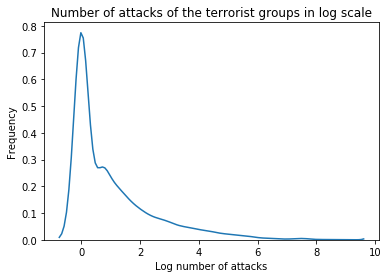

In [149]:
# Activity of different groups : frequencies of number of terrorist attacks
group_df = terrorism_df[['gname','nkill']]
group_df = group_df[group_df['gname'] != 'Unknown']
grouped_df= group_df.groupby('gname').agg(['sum','count'])
grouped_df.columns = [ '_'.join(str(i) for i in col) for col in grouped_df.columns]
grouped_df.reset_index(inplace=True)
grouped_df = grouped_df[(grouped_df.nkill_count >= 1)]

# Initialize figure and ax
fig, ax = plt.subplots()

logged = np.log(grouped_df.nkill_count)
ax = sns.distplot(logged,bins=np.arange(logged.min(), logged.max()),ax=ax, hist=False)
ax.set(ylabel='Frequency', xlabel='Log number of attacks')
ax.set_title('Number of attacks of the terrorist groups in log scale')

plt.show()

In [150]:
# We get the most active groups in term of attacks
grouped_df.sort_values(by='nkill_count',ascending=False).head(10)

,gname,nkill_sum,nkill_count
3039,Taliban,30389.0,7056
1482,Islamic State of Iraq and the Levant (ISIL),29626.0,4522
2845,Shining Path (SL),8085.0,3687
671,Boko Haram,18714.0,2154
164,Al-Shabaab,6403.0,2135
2181,New People's Army (NPA),2430.0,2008
2624,Revolutionary Armed Forces of Colombia (FARC),3942.0,2001
854,Communist Party of India - Maoist (CPI-Maoist),2234.0,1889
588,Basque Fatherland and Freedom (ETA),727.0,1769
1433,Irish Republican Army (IRA),1060.0,1757


In [0]:
# Most of the groups have less than 30 attacks, we keep only the most active groups
grouped_df = grouped_df[(grouped_df.nkill_count >= 30)]
imp_ter_groups = list(grouped_df.gname.unique())

In [0]:
# Separate the groups by decade to get more significant historical results
terror_country_df = terrorism_df[['gname','country_txt','iyear','region_txt']]
terror_country_df = terror_country_df[terror_country_df['gname'] != 'Unknown']
terror_country_df = terror_country_df[terror_country_df.gname.isin(imp_ter_groups)]
terror_country_df['edges'] = list(zip(terror_country_df.gname, terror_country_df.country_txt))
decades = ['1970-1980','1980-1990','1990-2000','2000-2010','2010-2018']
dict_terror_group = {}
dict_country_group = {}
dict_edges = {}
for d in decades:
    start = d.split('-')[0]
    end   = d.split('-')[1]
    dict_terror_group[d] = list(terror_country_df[(terror_country_df.iyear >= int(start)) &  (terror_country_df.iyear < int(end))].gname.unique())
    dict_country_group[d] = list(terror_country_df[(terror_country_df.iyear >= int(start)) &  (terror_country_df.iyear < int(end))].country_txt.unique())
    dict_edges[d] = terror_country_df[(terror_country_df.iyear >= int(start)) &  (terror_country_df.iyear < int(end))].edges.to_list() 
    
dict_regions = dict(zip(terror_country_df.country_txt, terror_country_df.region_txt))

In [0]:
# Create bipartite graph with Networkx
dict_graph = {}
for d in decades:    
    dict_graph[d] = nx.Graph()
    
    # Add nodes with the node attribute "bipartite"
    dict_graph[d].add_nodes_from(dict_terror_group[d], bipartite=0)
    
    for country in dict_country_group[d]:
        dict_graph[d].add_node(country, region=dict_regions[country],bipartite=1)
        
    # Add edges only between nodes of opposite node sets
    dict_graph[d].add_edges_from(dict_edges[d])

In [154]:
# Since the graphs are disconnected, we only keep the main part (the graph is the greatest number of nodes)
dict_main_graph = {}
for d in decades:  
    # extract subgraphs
    sub_graphs = nx.connected_component_subgraphs(dict_graph[d])
    print(d)
    max_nodes = 0
    nb_subgraph = 0
    for i, sg in enumerate(sub_graphs):
        if sg.number_of_nodes() > max_nodes:
            dict_main_graph[d] = sg
            max_nodes = sg.number_of_nodes()
    print ("There is {} subgraphs in total, the main one has {} nodes".format(i+1, max_nodes))

1970-1980
There is 12 subgraphs in total, the main one has 133 nodes
1980-1990
There is 6 subgraphs in total, the main one has 198 nodes
1990-2000
There is 6 subgraphs in total, the main one has 255 nodes
2000-2010
There is 6 subgraphs in total, the main one has 231 nodes
2010-2018
There is 7 subgraphs in total, the main one has 253 nodes


In [155]:
# The bipartite graph on its own is not usefull. However, once projected on the county side we can learn some valuable insights.
output_notebook()

dict_graphs = {}
for d in decades:
    print(d)
    G = dict_main_graph[d]
    proj = bipartite.weighted_projected_graph(G, nx.bipartite.sets(G)[1])
    to_drop = []
    for el in list(proj.edges(data=True)):
        if el[2]['weight'] <= 2: # We remove the edges that have less than 3 connections on the original bipartite graph
            to_drop.append(el[:2])

    proj.remove_edges_from(to_drop)
    proj.remove_nodes_from(list(nx.isolates(proj)))
    
    fig = bokeh_graph(proj,'Network for the ' + d + ' decade',False,False)
    dict_graphs[d] = fig

1970-1980
1980-1990
1990-2000
2000-2010
2010-2018


In [156]:
output_file("All_graphs.html")

tab_list = []
for d in decades:
    p = dict_graphs[d]
    tab = Panel(child=p, title=d)
    tab_list.append(tab)

tabs = Tabs(tabs=tab_list)

show(tabs)


The graphs above give an overview of the links that exist between countries for different time periods. Feel free to explore the interactive graph. Now that we know that we have the capability to create this type of graph, we can use it to extract some valuable insights. If a country has been attacked, can we predict another upcoming attack on another country? We try to answer this question by using data before 2010 to predict attacks between 2011 and 2018. We first create a graph with the data before 2010 in which we exclude all the week edges (less than 10 connections). Therefore, we can suppose that the graph below represents meaningful relations between countries. We observe some clusters appear in function of the region, which is an indicator that the links represent real connections.

In [0]:
group_df = terrorism_df[['gname','nkill']]
group_df = group_df[group_df['gname'] != 'Unknown']
grouped_df= group_df.groupby('gname').agg(['sum','count'])
grouped_df.columns = [ '_'.join(str(i) for i in col) for col in grouped_df.columns]
grouped_df.reset_index(inplace=True)
terror_country_df = terrorism_df[['gname','country_txt','iyear','region_txt']]
terror_country_df = terror_country_df[terror_country_df['gname'] != 'Unknown']
terror_country_df['edges'] = list(zip(terror_country_df.gname, terror_country_df.country_txt))

terror_70_10 = list(terror_country_df[terror_country_df.iyear <= 2010].gname.unique())
country_70_10 = list(terror_country_df[terror_country_df.iyear <= 2010].country_txt.unique())
edges_70_10 = terror_country_df[terror_country_df.iyear <= 2010].edges.to_list() 

dict_regions_70_10 = dict(zip(terror_country_df.country_txt, terror_country_df.region_txt))

In [0]:
G_70_10 = nx.Graph()

# Add nodes with the node attribute "bipartite"
G_70_10.add_nodes_from(terror_70_10, bipartite=0)

for country in country_70_10:
    if 'Germany' in country:
        G_70_10.add_node('Germany', region=dict_regions_70_10[country],bipartite=1)
    else:
        G_70_10.add_node(country, region=dict_regions_70_10[country],bipartite=1)

# Add edges only between nodes of opposite node sets
updated_edges_edges_70_10 = []
for edge in edges_70_10:
    if 'Germany' in edge[1]:
        updated_edges_edges_70_10.append((edge[0],'Germany'))
    else:
        updated_edges_edges_70_10.append(edge)
        
G_70_10.add_edges_from(updated_edges_edges_70_10)

In [159]:
sub_graphs = nx.connected_component_subgraphs(G_70_10)

max_nodes = 0
nb_subgraph = 0
for i, sg in enumerate(sub_graphs):
    if sg.number_of_nodes() > max_nodes:
        g_70_10 = sg
        max_nodes = sg.number_of_nodes()
print ("There is {} subgraphs in total, the main one has {} nodes".format(i+1, max_nodes))

There is 23 subgraphs in total, the main one has 2866 nodes


In [160]:
G_70_10 = g_70_10
proj_70_10 = bipartite.weighted_projected_graph(G_70_10, nx.bipartite.sets(G_70_10)[1])
to_drop = []
for el in list(proj_70_10.edges(data=True)):
    if el[2]['weight'] < 10: # We remove the edges that have less than 10 connections on the original bipartite graph
        to_drop.append(el[:2])
        
to_rm = []
for node in proj_70_10.nodes:
    if not len(proj_70_10.nodes[node]):
        to_rm.append(node)

proj_70_10.remove_edges_from(to_drop)
proj_70_10.remove_nodes_from(list(nx.isolates(proj_70_10)))
proj_70_10.remove_nodes_from(to_rm)

fig = bokeh_graph(proj_70_10,'Network between 1970 and 2010',True,False)

We used only the data before 2010. Since we have discarted from the graph all the week egdes (less than 10 connections), we can suppose that the graph above represent real relations between countries. We see some cluster appear in function of the region (color). The next step will be to see if the countries that have been attacked after 2010 have the same kind edges. The goal is not to predict the next attack but we can suppose that if a country is attacked there is a higher chance that a connected country will also be attacked. The graph of the data after 2010 is presented below. In this graph, we want to keep all the connections because all the attacks are equally important.

In [0]:
group_df = terrorism_df[['gname','nkill']]
group_df = group_df[group_df['gname'] != 'Unknown']
grouped_df= group_df.groupby('gname').agg(['sum','count'])
grouped_df.columns = [ '_'.join(str(i) for i in col) for col in grouped_df.columns]
grouped_df.reset_index(inplace=True)
terror_country_df = terrorism_df[['gname','country_txt','iyear','region_txt']]
terror_country_df = terror_country_df[terror_country_df['gname'] != 'Unknown']
terror_country_df['edges'] = list(zip(terror_country_df.gname, terror_country_df.country_txt))

terror_10_18 = list(terror_country_df[terror_country_df.iyear > 2010].gname.unique())
country_10_18 = list(terror_country_df[terror_country_df.iyear > 2010].country_txt.unique())
edges_10_18 = terror_country_df[terror_country_df.iyear > 2010].edges.to_list() 

dict_regions_10_18 = dict(zip(terror_country_df.country_txt, terror_country_df.region_txt))

In [0]:
G_10_18 = nx.Graph()

# Add nodes with the node attribute "bipartite"
G_10_18.add_nodes_from(terror_10_18, bipartite=0)

for country in country_10_18:
    G_10_18.add_node(country, region=dict_regions_10_18[country],bipartite=1)

# Add edges only between nodes of opposite node sets
G_10_18.add_edges_from(edges_10_18)

In [163]:
sub_graphs = nx.connected_component_subgraphs(G_10_18)

max_nodes = 0
nb_subgraph = 0
for i, sg in enumerate(sub_graphs):
    if sg.number_of_nodes() > max_nodes:
        g_10_18 = sg
        max_nodes = sg.number_of_nodes()
print ("There is {} subgraphs in total, the main one has {} nodes".format(i+1, max_nodes))

There is 19 subgraphs in total, the main one has 1045 nodes


In [164]:
G_10_18 = g_10_18
proj_10_18 = bipartite.weighted_projected_graph(G_10_18, nx.bipartite.sets(G_10_18)[1])

        
to_rm = []
for node in proj_10_18.nodes:
    if not len(proj_10_18.nodes[node]):
        to_rm.append(node)

proj_10_18.remove_nodes_from(list(nx.isolates(proj_10_18)))
proj_10_18.remove_nodes_from(to_rm)

fig = bokeh_graph(proj_10_18,'Network between 2010 and 2018',True,False)

This graph has more connections since we keep all the nodes. To evaluate the quality of the previous links, we want to know how many edges are in common between the previous graph and this one. We observe that 85% of the edges that were present in the past are still present now. Even if we can not say anything about attacks in new countries, there is indeed a higher chance that a country that shares a link with a recently attacked country will also be the target of a new attack. This can help linked countries to be better prepare for an attack and hopefully prevent it.

In [165]:
edges_70_10 = [edge for edge in proj_70_10.edges]
edges_10_18 = [edge for edge in proj_10_18.edges]
count_sim = 0
for edge in edges_10_18:
    if edge in edges_70_10:
        count_sim += 1
similarity = count_sim/len(edges_70_10)
print('There is a {:.3}% similarity'.format(similarity*100))

There is a 85.5% similarity


In [0]:
html = file_html(tabs, CDN, "my plot")

In [0]:
def write_html_to_txt(html,title):
    file = open(title + '.txt',"w")
    for line in html.split('\n'):
        file.write(line + '\n')
    file.close()

# Mini Quiz : Word Cloud

Now, time to test your knowledge about geopolitics all around the world and to see if you have been a careful reader of our data story.

In [0]:
file = "https://raw.githubusercontent.com/CharlesCoster/ada-project-terrorism-impact/master/ada_data/wordcloud_terror.csv"
wordcloud_terror_df = pd.read_csv(file)

In [0]:
def save_images():
    for region,imagename in zip(['North America', 'South Asia', 'Middle East & North Africa', 'South America' , 'Western Europe'],
                                ['image/north_america.png', 'image/south_asia.jpg', 'image/africa_north.png', 'image/south_america.jpg' ,'image/western_europe.jpeg']):
        for decade in ['70', '75', '80','85','90','95','00','05','10']:
            decade = int(decade)
            simple_wordcloud(bag_of_words,region,decade,imagename,save=True)

In [0]:
def word_cloud(dict_,region):
    for year in dict_[region].keys():
        if len(dict_[region][year]) > 0:
            print(year)
            wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate_from_frequencies(dict_[region][year])
            plt.figure()
            plt.imshow(wordcloud, interpolation="bilinear")
            plt.axis("off")
            plt.show()

In [0]:
def group_decade(dict_,region,decade):
    dict_region = dict_[region]
    dict_decade = defaultdict(int)
    for year in dict_region.keys():
        if year%100 >= decade and year%100 < decade+10:
            for word, freq in  dict_region[year].items():
                dict_decade[word] += freq
    return dict_decade

In [0]:
def simple_wordcloud(dict_complete,region,decade,imagename,save=False):

    dict_ = group_decade(dict_complete,region,decade)
    if len(dict_) > 0:
        mask = np.array(Image.open(imagename))
        wc = WordCloud(background_color="white", max_words=2000, mask=mask,contour_width=0, contour_color='steelblue').generate_from_frequencies(dict_)
        
        if save:
            wc.to_file('./image/wordcloud_' + region + '_' + str(decade) + '.png')
        
        return wc

In [0]:
def group_all(dict_):
    dict_complete = defaultdict(int)
    for region in dict_.keys():
        dict_region = dict_[region]
        for year in dict_region.keys():
            for word, freq in dict_region[year].items():
                dict_complete[word] += freq
    return dict_complete

### Importance of context

The dataset contains a column that present the context of the attack, it include general information about
the political, social, or economic climate at the time of the attack. Therefore, we want, with this analysis, to try to get a better understanding of the reasons that can lead to an attack.

The first step is then to collect a bag of meaningful words

In [174]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english')) 
stop_words.add('unknown')
stop_words.add('motive')
stop_words.add('specific')
stop_words.add('however')

lemmatizer = WordNetLemmatizer() 

rof = ['North America','South Asia', 'Middle East & North Africa', 'South America','Western Europe'] # regions of interrest
bag_of_words = {}
for region in rof:
    bag_of_words[region] = {}
    df = wordcloud_terror_df[wordcloud_terror_df.region_txt == region]
    for year, group in df.groupby('iyear'):
        word_dict  = defaultdict(int)
        for txt in group.motive.dropna():
            res = re.findall(r'\w+',txt) 
            for word in res:
                if word.lower() not in stop_words:
                    lem_word = lemmatizer.lemmatize(word)
                    word_dict[lem_word] += 1
                    
        bag_of_words[region][year] = OrderedDict(sorted(word_dict.items(), key=operator.itemgetter(1),reverse=True)[:100])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


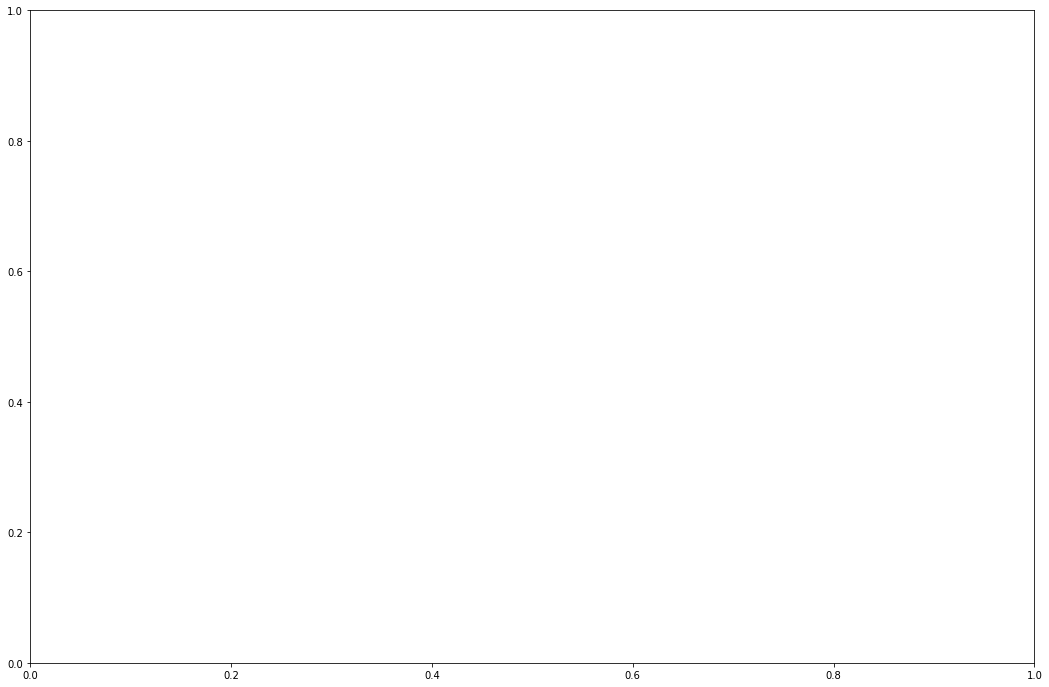

In [175]:
def f(region,decade):
    decade = int(decade)
    dict_image = {'North America' : 'North%20America', 
                  'South Asia' : 'South%20Asia', 
                  'Middle East & North Africa' : 'Middle%20East%20%26%20North%20Africa', 
                  'South America' : 'South%20America' , 
                  'Western Europe' : 'Western%20Europe'}
    wc = plt.imread('https://raw.github.com/CharlesCoster/ada-project-terrorism-impact/master/image/image_wordcloud/wordcloud_{}_{}.png'.format(dict_image[region],decade))
    ax_neu.imshow(wc)
    fig.canvas.draw()
    display(fig)

fig = plt.figure(figsize=(18, 12))
# # ax_orig = fig.add_subplot(121) 
ax_neu = fig.add_subplot(111) 

In [176]:
region_w = widgets.Dropdown(
    options=['North America', 'South Asia', 'Middle East & North Africa', 'South America' , 'Western Europe'],
    value='North America',
    description='Region:',
)
decade_w = widgets.SelectionSlider(
    options=['70', '75', '80','85','90','95','00','05','10'],
    value='70',
    description='Decade:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

interact(f, region=region_w,decade=decade_w);

interactive(children=(Dropdown(description='Region:', options=('North America', 'South Asia', 'Middle East & N…

From this interactive worcloud, we realised that we can actually guess the politcal context of a geographical region (in a given decade) based on the motive of the attacks. That means that terrorism has a really close connection to the historical context. Most of the terrorist groups have been created after an important political change or event, and reflect these changes. For example, FARC was formed in 1964 by Manuel Marulanda Vélez and other PCC members, after a military attack on the community of Marquetalia. 

# Conclusion

Terrorism can take various forms and has been displayed in many different geopolitical contexts. Therefore, it is a highly complex subject that cannot be explained easily. Nevertheless, with our analysis, we tried to make things clearer. To begin with, a first descriptive analysis allowed us to find correlations between terrorism and societal behaviors. As a consequence, we successfully illustrated one of the most important consequences of terrorism is to establish a crisis climate and spread fear amongst the population. The next analysis is more focused on terrorist groups. Then, we tried to find some recurrent patterns, in particular, in the groups’ origin and operation mode (weapons, attack types, targets). We also categorized groups in four categories of motivations and four categories of ideology, in order to observe the evolution of these categories over time. From those observations, we were able to some extent, to understand the prevailing opposing ideologies and motivation worldwide since 1970. For a deeper analysis, we focused on global terrorism in Northern countries, we analyzed in detail 6 groups which marked the History of Northern and Western countries: making deadly, violent, destructive and frequent attacks on their territory. Finally, we ended our analysis by trying to come with a tool able to “predict” similarly targeted countries. Thus, we created a network of countries sadly linked by their terrorism story. The goal of this network is to prevent attacks in highly connected countries of a targeted country, by enforcing more security measures as well as individual safety precautions when attacks occur in a linked country. To conclude with, terrorism is a vast and interesting subject to understand, even though it confronts some of our deepest fear. We do believe that this knowledge is power and that it might be our only weapon against generalized ignorance and globalized violence.